# Décision bayesienne et maximum de vraisemblance

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import uniform

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.naive_bayes import GaussianNB

In [3]:
# fonction d'affichage des matrices de confusion (copié/collé du site de scikit-learn)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function printed and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

On dispose pour d'un ensemble de données d’apprentissage labellisées contenues dans le fichier `temperatureapp.txt`. 
Chaque ligne du fichier est un individu caractérisé par la température de son corps (colonne 1) ainsi que par son état de santé (colonne 2). L'état de santé est binaire. Un individu est considéré "bien portant" (`1`) ou "malade" (`2`).
Cet ensemble d'apprentissage comprend 500 individus dont 450 appartiennent à la classe 1 ("bien portant") et 50 à la classe 2 ("malade").

Avec ces données on veut réaliser un classifieur Bayésien qui permettra de déterminer automatiquement l'état de santé d'un individu à partir de la température de son corps. 

On dispose aussi d'un ensemble de données de test `temperaturetest.txt` qui sera utilisé ultérieurement pour valider le classifieur appris.

### Chargement des données

In [4]:
class_labels = ['bien portant ($C_1$)','malade ($C_2$)']
app = pd.read_csv("temperatureapp.txt",sep=' ',names=['temp','class'])
temp_app = np.squeeze(app["temp"].values)
classe_app = np.squeeze(app["class"].values)
label_app = np.array([class_labels[i-1] for i in classe_app])
test = pd.read_csv("temperaturetest.txt",sep=' ',names=['temp','class'])
temp_test = np.squeeze(test["temp"].values)
classe_test = np.squeeze(test["class"].values)
label_test = np.array([class_labels[i-1] for i in classe_test])

### histogramme des températures sachant la classe

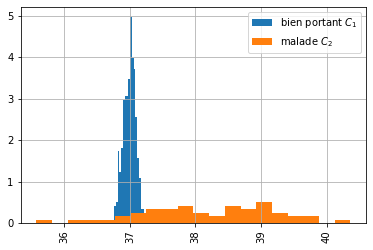

In [5]:
ax = plt.axes()
plt.grid()#color='lightgray',linestyle='--'
bp = app.hist(column='temp',by='class',ax=[ax,ax],bins=20, density=1)
ax.legend(['bien portant $C_1$','malade $C_2$'])
plt.title('') ;

### Réalisation du classifieur

Les jeux de températures correspondant à chacune des deux classes (de l'ensemble d'apprentissage).

In [6]:
temp_c1_app = np.squeeze(app.loc[app['class'] == 1,["temp"]].values)
temp_c2_app = np.squeeze(app.loc[app['class'] == 2,["temp"]].values)

Dans la suite, on va essayer de comprendre comment les données sont réparties et ce que fait le classifieur.
Comme ici on a un exemple "jouet" en 1D, on pourra voir clairement comment les données sont réparties.
On aura donc la possibilité d'afficher des histogrammes et des densités de probabilité (conditionnelles ou a posteriori) pour les différentes classes ou pour l'ensemble de données complet.
Pour cela, on crée des maillages réguliers des températures.

In [7]:
t_maillage = np.linspace(min(app["temp"]),max(app["temp"]),3000)     # maillage de l'intervalle des T° pour l'apprentissage
t_maillage_1 = np.linspace(min(temp_c1_app),max(temp_c1_app),100)   # maillage de l'intervalle des T° pour C1
t_maillage_2 = np.linspace(min(temp_c2_app),max(temp_c2_app),100)   # maillage de l'intervalle des T° pour C2

#### Détermination des probabilités a priori

In [8]:
pC1 = len(temp_c1_app)/len(app)
pC2 = len(temp_c2_app)/len(app)
print('probabilité a priori de la classe 1 ("bien portant") :',pC1)
print('probabilité a priori de la classe 2 ("malade")       :',pC2)

probabilité a priori de la classe 1 ("bien portant") : 0.9
probabilité a priori de la classe 2 ("malade")       : 0.1


#### Détermination des probabilité conditionnelles pour chacune des deux classes ( $p(x/C_1)$ et $p(x/C_2)$ )

Ici, on va supposer que chaque type d'individu ("bien portant" ou "malade") a une température distribuée selon une loi normale. (C'est une hypothèse forte. Cela implique que l'on peut résumer tout un ensemble de points avec seulement deux paramètres. C'est la raison pour laquelle on n'a que deux paramètres à estimer dans la suite.)

In [9]:
loiRetenue = norm
#loiRetenue = uniform

On aura donc pour chaque classe $i$ deux paramètres à déterminer ($\mu_i$ et $\sigma_i$). 

$\mu_i$ est un paramètre de position ("location" en anglais)
$\sigma_i$ est un paramètre d'échelle ("scale" en anglais)


Ces paramètres vont être estimés par maximum de vraisemblance sur le jeu de données d'apprentissage. 

In [10]:
print('loi de probabilité retenue : ',loiRetenue.name)

# estimation des paramètres de la loi
if loiRetenue == norm or loiRetenue == uniform:
    loc_1, scale_1 = loiRetenue.fit(temp_c1_app)
    loc_2, scale_2 = loiRetenue.fit(temp_c2_app)

# affichage des paramètres estimés
if loiRetenue == norm:
    print('paramètres de la classe 1 ("bien portant") : mu = {:5.2f}   sigma = {:5.2f}'.format(loc_1,scale_1))
    print('paramètres de la classe 2 ("malade")       : mu = {:5.2f}   sigma = {:5.2f}'.format(loc_2,scale_2))
elif loiRetenue == uniform:
    print('paramètres de la classe 1 ("bien portant") : a = {:5.2f}   b = {:5.2f}'.format(loc_1,scale_1))
    print('paramètres de la classe 2 ("malade")       : a = {:5.2f}   b = {:5.2f}'.format(loc_2,scale_2))


loi de probabilité retenue :  norm
paramètres de la classe 1 ("bien portant") : mu = 37.00   sigma =  0.09
paramètres de la classe 2 ("malade")       : mu = 38.18   sigma =  1.00


Il n'est pas anodin de supposer que les températures sont distribuées selon une loi normale. 
Quand on se base sur une hypothèse, il faut a minima s'assurer de son bien fondé.

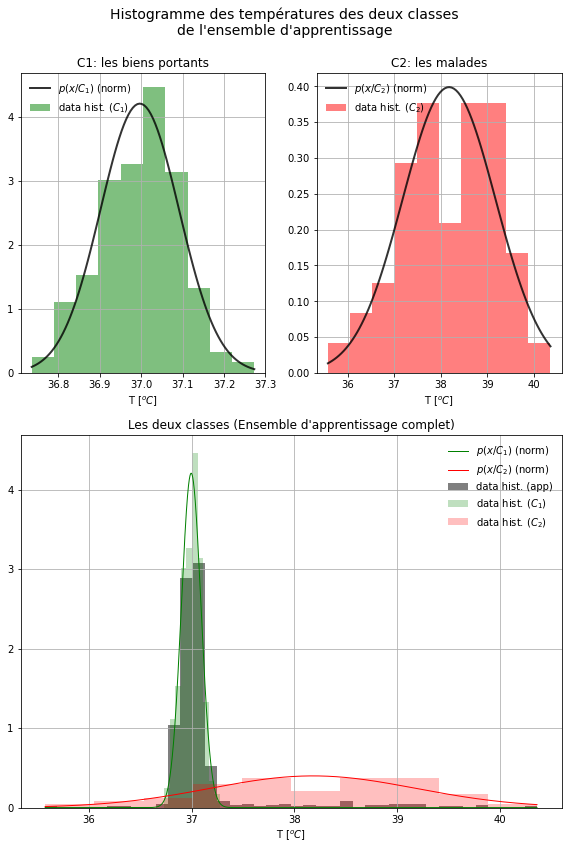

In [11]:
# Hitogrammes par classe
fig = plt.figure(figsize=(8,12))
gs = fig.add_gridspec(12, 2)

# les bien portant 
ax1 = fig.add_subplot(gs[1:6, 0])
ax1.hist(temp_c1_app, density=True, histtype='stepfilled',color='green', alpha=0.5, label='data hist. ($C_1$)')
ax1.plot(t_maillage_1, loiRetenue.pdf(t_maillage_1,loc_1,scale_1),'k-', lw=2, alpha=0.8, label="$p(x/C_1)$ ("+loiRetenue.name+')')
ax1.legend(loc='upper left', frameon=False)
ax1.set(title='C1: les biens portants')
ax1.set(xlabel='T [$^oC$]')
plt.grid(True)

# les malades
ax2 = fig.add_subplot(gs[1:6, 1])
ax2.hist(temp_c2_app, density=True, histtype='stepfilled', color='red', alpha=0.5, label='data hist. ($C_2$)')
ax2.plot(t_maillage_2, loiRetenue.pdf(t_maillage_2,loc_2,scale_2),'k-', lw=2, alpha=0.8, label="$p(x/C_2)$ ("+loiRetenue.name+')')
ax2.legend(loc='upper left', frameon=False)
ax2.set(title='C2: les malades')
ax2.set(xlabel='T [$^oC$]')
plt.grid(True)

# les deux (i.e. l'ensemble d'apprentissage au complet) 
ax3 = fig.add_subplot(gs[6:, :])
ax3.hist(temp_app, density=True, bins=40,color='black', histtype='stepfilled', alpha=0.5, label='data hist. (app)')
ax3.hist(temp_c1_app, density=True, color='green', histtype='stepfilled', alpha=0.25, label='data hist. ($C_1$)')
ax3.hist(temp_c2_app, density=True, color='red',histtype='stepfilled', alpha=0.25, label='data hist. ($C_2$)')
ax3.plot(t_maillage, loiRetenue.pdf(t_maillage,loc_1,scale_1),'g-', lw=1, alpha=1, label="$p(x/C_1)$ ("+loiRetenue.name+')')
ax3.plot(t_maillage, loiRetenue.pdf(t_maillage,loc_2,scale_2),'r-', lw=1, alpha=1, label="$p(x/C_2)$ ("+loiRetenue.name+')')
ax3.legend(loc='best', frameon=False)
ax3.set(title="Les deux classes (Ensemble d'apprentissage complet)")
ax3.set(xlabel="T [$^oC$]") 
plt.grid(True)

plt.suptitle("Histogramme des températures des deux classes\n" + 
             "de l'ensemble d'apprentissage",fontsize=14)
plt.tight_layout()


#### Détermination des probabilité a posteriori pour chacune des deux classes ( $p(C_1/x)$ et $p(C_2/x)$ )

Ici on va chercher à afficher les probabilités a posteriori pour chacune des classes en se basant sur ce que l'on a estimé. 

On doit donc déterminer : 
$$p(C_1/x)=\frac{p(x/C_1)p(C_1)}{p(x)} \quad\text{ et }\quad p(C_2/x)\frac{p(x/C_2)p(C_2)}{p(x)}$$

#### Affichage des probabilités
Pour réaliser un affichage, on va calculer les probabilités $p(C_1/x)$ et $p(C_2/x)$ sur un maillage régulier de temératures. Pour avoir un affichage correcte, on va donc calculer p(x) pour les valeurs de températures contenues dans `t_maillage`. (`t_maillage` contient un maillage des valeurs de températures sur l'intervalle des valeurs apprises). 

**Calcul de** $\mathbf{p(x) = p(x/C_1) \times p(C_1) +  p(x/C_2) \times p(C_2)}$

In [12]:
p_t_maillage = loiRetenue.pdf(t_maillage,loc_1,scale_1) * pC1 + loiRetenue.pdf(t_maillage,loc_2,scale_2) * pC1

**Calculs de $\mathbf{p(C_1/x)}$ et de $\mathbf{p(C_2/x)}$**

In [13]:
p_c1_t_maillage = loiRetenue.pdf(t_maillage,loc_1,scale_1) * pC1 / p_t_maillage
p_c2_t_maillage = loiRetenue.pdf(t_maillage,loc_2,scale_2) * pC2 / p_t_maillage

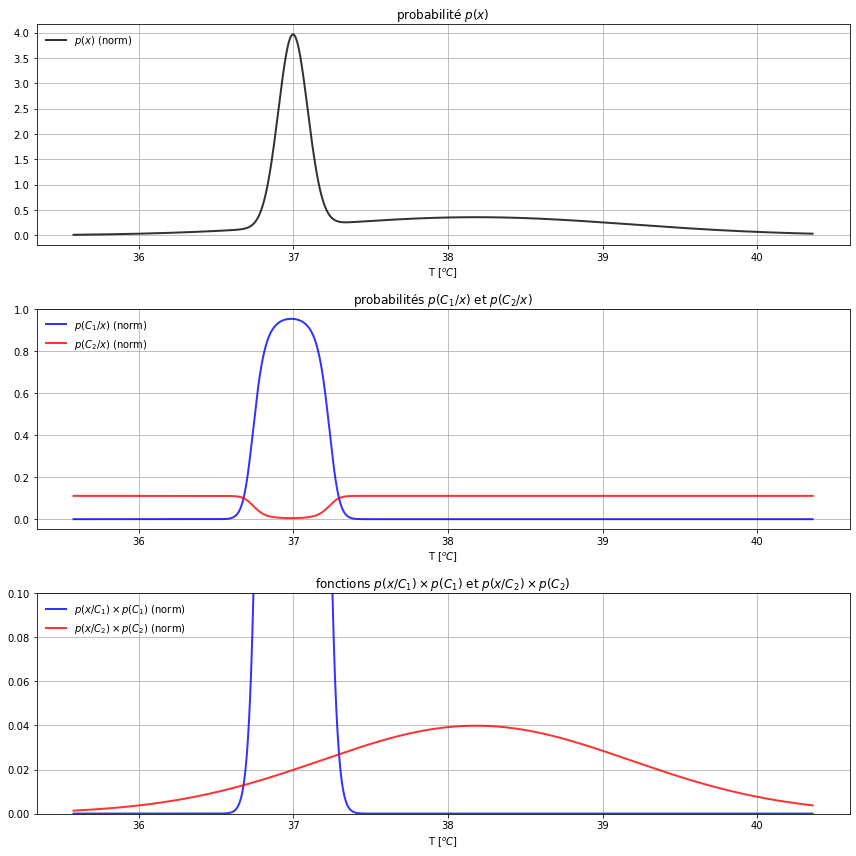

In [14]:
fig,ax = plt.subplots(3,1,figsize=(12,12))

ax[0].plot(t_maillage, p_t_maillage,'k-', lw=2, alpha=0.8, label="$p(x)$ ("+loiRetenue.name+')')
ax[0].legend(loc='upper left', frameon=False)
ax[0].set(title='probabilité $p(x)$')
ax[0].set(xlabel='T [$^oC$]')
ax[0].grid(True)

ax[1].plot(t_maillage, p_c1_t_maillage,'b-', lw=2, alpha=0.8, label="$p(C_1/x)$ ("+loiRetenue.name+')')
ax[1].plot(t_maillage, p_c2_t_maillage,'r-', lw=2, alpha=0.8, label="$p(C_2/x)$ ("+loiRetenue.name+')')
ax[1].legend(loc='upper left', frameon=False)
ax[1].set(title='probabilités $p(C_1/x)$ et $p(C_2/x)$')
ax[1].set(xlabel='T [$^oC$]')
ax[1].grid(True)

ax[2].plot(t_maillage, loiRetenue.pdf(t_maillage,loc_1,scale_1) * pC1,'b-', lw=2, alpha=0.8, label=r"$p(x/C_1)\times p(C_1)$ ("+loiRetenue.name+')')
ax[2].plot(t_maillage, loiRetenue.pdf(t_maillage,loc_2,scale_2) * pC2,'r-', lw=2, alpha=0.8, label=r"$p(x/C_2)\times p(C_2)$ ("+loiRetenue.name+')')
ax[2].legend(loc='upper left', frameon=False)
ax[2].set(title=r'fonctions $p(x/C_1) \times p(C_1)$ et $p(x/C_2) \times p(C_2)$')
ax[2].set(xlabel='T [$^oC$]')
ax[2].set(ylim=(0,.1))
plt.grid(True)

plt.tight_layout()


Comme nous ne nous intéressons qu'à la classification, il est possible de se limiter à l'utilisation des deux fonctions $p(x/C_1)p(C_1)$ et $p(x/C_2)p(C_2)$ qui nous permettrons de prendre la même décision. 

### Prise de décision 

Ici, pour l'ensemble d'apprentissage, on va déterminer la classe estimée par le classifieur.

In [15]:
decision_app = 1 + (loiRetenue.pdf(temp_app,loc_1,scale_1) * pC1 < loiRetenue.pdf(temp_app,loc_2,scale_2) * pC2).astype(int)

Ici, comme on est dans un cas unidimensionnel, on peut simplement affiché les décisions prises par le classifieur.

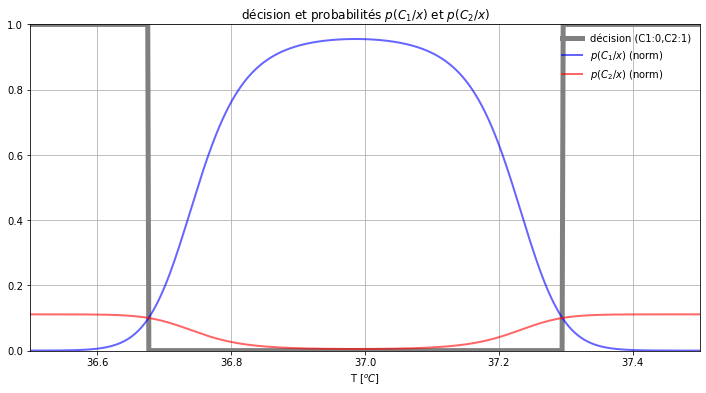

In [16]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(t_maillage,(loiRetenue.pdf(t_maillage,loc_1,scale_1) * pC1 < loiRetenue.pdf(t_maillage,loc_2,scale_2) * pC2).astype(int),
        '-',color='gray', lw=5,label='décision (C1:0,C2:1)')
ax.plot(t_maillage, p_c1_t_maillage,'b-', lw=2, alpha=0.6, label="$p(C_1/x)$ ("+loiRetenue.name+')')
ax.plot(t_maillage, p_c2_t_maillage,'r-', lw=2, alpha=0.6, label="$p(C_2/x)$ ("+loiRetenue.name+')')
ax.legend(loc='upper right', frameon=False)
ax.set(title='décision et probabilités $p(C_1/x)$ et $p(C_2/x)$')
ax.set(xlabel='T [$^oC$]')
ax.set(ylim=(0,1))
ax.set(xlim=(36.5,37.5))
ax.grid(True)


On constate qu'ici on pourrait réaliser un classifieur à partir de deux valeurs seuils. 

En règle général, les dimensions du problème sont plus importantes, on ne peut pas aussi simplement affiché la fonction de décision. Pour analyser les résultats d'un classifieur, on peut calculer une matrice de confusion.

Ici, on calcule donc une matrice de confusion sur nos données d'apprentissage.
(On compare la classe connue `classe_app` à la décision prise par le classifieur `decision_app`.) 

In [17]:
matrice_confusion_app = confusion_matrix(classe_app, decision_app)
print('matrice de confusion (app) :\n',matrice_confusion_app)

matrice de confusion (app) :
 [[450   0]
 [  8  42]]


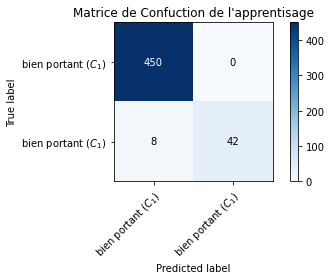

In [18]:
plot_confusion_matrix(classe_app, decision_app, 
                      classes=label_app,
                      title="Matrice de Confuction de l'apprentisage")

### Au delà de l'ensemble d'apprentissage

On a les performances du classifieur sur les données qui ont servi à estimer ses paramètres.
Comment se comportera-t-il quand on voudra l'utiliser avec de nouvelles données ?

Pour cela, on a gardé quelques données (appelé ensemble de test ici) qui vont nous servir pour avoir une idée de la qualité de ces perfomances par la suite.

In [19]:
decision_test = 1 + (loiRetenue.pdf(temp_test,loc_1,scale_1) * pC1 < loiRetenue.pdf(temp_test,loc_2,scale_2) * pC2).astype(int)
matrice_confusion_test = confusion_matrix(classe_test, decision_test)
print('matrice de confusion (test) :\n',matrice_confusion_test)

matrice de confusion (test) :
 [[89  1]
 [ 2  8]]


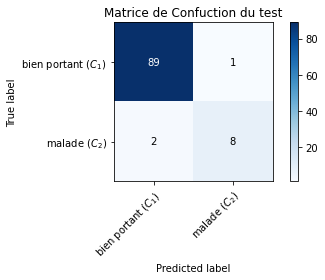

In [20]:
plot_confusion_matrix(classe_test, decision_test, 
                      classes=label_test,
                      title='Matrice de Confuction du test') ;

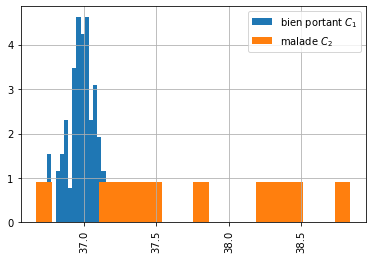

In [21]:
ax = plt.axes()
plt.grid()#color='lightgray',linestyle='--'
bp = test.hist(column='temp',by='class',ax=[ax,ax],bins=20, density=1)
ax.legend(['bien portant $C_1$','malade $C_2$'])
plt.title('');

### La classification bayesienne (naive Bayes) avec scikit learn

matrice de confusion (appretissage):
 [[450   0]
 [  8  42]]
matrice de confusion (test):
 [[89  1]
 [ 2  8]]


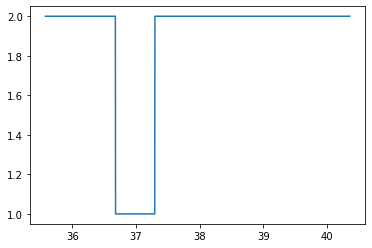

In [22]:
# création d'un classifieur bayesien "gaussien" 
#  (avec probabilités a priori des classes specifiees)
clf = GaussianNB(priors=[pC1,pC2])

# apprentissage du classifieur a partir des données d'apprentissage
#clf.fit(temp_app.reshape(-1,1),classe_app.reshape(-1,1))
clf.fit(temp_app.reshape(-1,1),classe_app)

# un affichage (vite fait)
class_predite = clf.predict(t_maillage.reshape(-1,1))
plt.plot(t_maillage,class_predite,'-') 

# matrice de confusion sur l'apprentissage
matrice_confusion_app_ = confusion_matrix(classe_app.reshape(-1,1), clf.predict(temp_app.reshape(-1,1)))
print('matrice de confusion (appretissage):\n',matrice_confusion_app_)

# matrice de confusion sur le test
matrice_confusion_test_ = confusion_matrix(classe_test.reshape(-1,1), clf.predict(temp_test.reshape(-1,1)))
print('matrice de confusion (test):\n',matrice_confusion_test_)

***
**On est jamais mieux servi que par soi-même.**  
**If you want something done right, do it yourself.**

[scipy](https://www.scipy.org/) - [pandas](https://pandas.pydata.org/) - [Numpy and Scipy](https://docs.scipy.org/doc/) - [matplotlib](https://matplotlib.org/) - [scikit-learn](http://scikit-learn.org/stable/) - [seaborn](https://seaborn.pydata.org/)